# # Analysis of low-pass filter data taken with Audio Codec

This routine accepts the data files written by the Processing sketch "StructuredReceive3_bin" and finds the transfer function by dividing the digitized output of the unit under test by the white noise spectrum input to the unit. In this case the device is a simple resistor-capacitor low-pass filter. A model of that filter is fit to the measured transfer function and the results and residuals are plotted.

The first cell is initialization

In [1]:
%pylab inline 
import numpy.fft as fft # import FFT routines
import glob as gl # import file name parsing routines
import os # import file name manipulation routines
from scipy import optimize # import fitting routines

Populating the interactive namespace from numpy and matplotlib


Point to the directory where Process runs. Find make a list of all the files in that directory that have the name "DataXX.txt" where XX is anything.

In [2]:
directory='/Users/Ayelet/Desktop/NewArduino/ProcessingFiles/StructuredReceive3_bin'
datafiles=gl.glob(os.path.join(directory,'Data*.txt'))
#datafiles=datafiles[0:-1]
datafiles

['/Users/Ayelet/Desktop/NewArduino/ProcessingFiles/StructuredReceive3_bin\\Data0.txt',
 '/Users/Ayelet/Desktop/NewArduino/ProcessingFiles/StructuredReceive3_bin\\Data1.txt',
 '/Users/Ayelet/Desktop/NewArduino/ProcessingFiles/StructuredReceive3_bin\\Data2.txt',
 '/Users/Ayelet/Desktop/NewArduino/ProcessingFiles/StructuredReceive3_bin\\Data3.txt',
 '/Users/Ayelet/Desktop/NewArduino/ProcessingFiles/StructuredReceive3_bin\\Data4.txt',
 '/Users/Ayelet/Desktop/NewArduino/ProcessingFiles/StructuredReceive3_bin\\Data5.txt',
 '/Users/Ayelet/Desktop/NewArduino/ProcessingFiles/StructuredReceive3_bin\\Data6.txt',
 '/Users/Ayelet/Desktop/NewArduino/ProcessingFiles/StructuredReceive3_bin\\Data7.txt',
 '/Users/Ayelet/Desktop/NewArduino/ProcessingFiles/StructuredReceive3_bin\\Data8.txt']

Read the data file that is converted to analog and sent to the device under test. Those data are in the file "bandlimited.inc'

Read all the data files in the list found above and check that have 1024 numbers in them (this gets around the coccasional file that is missing some data). Compute the average timestream in the files.

In [3]:
s=genfromtxt("bandlimited.txt") # get the source array and average every other point
r=np.zeros(1024)
num = 0
for data_file in datafiles:
    ra=genfromtxt(data_file) #get the result array
    if (ra.size == 1024):
        r += ra
        num += 1
r/=num

Plot both the input function and the the average of the output data.

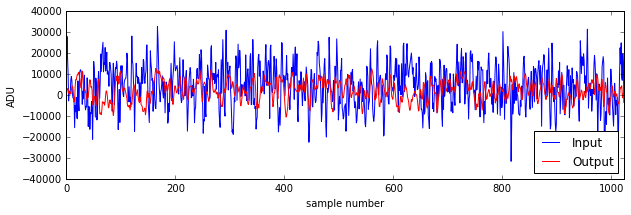

In [4]:
figure(figsize=(10,3))
xlabel('sample number')
ylabel('ADU')
xlim([0.,1024])
plot(s,label='Input')
plot(r,'r', label='Output')
legend(loc=4)

Make a function that models an RC lowpass function with a transfer function of

$$
T(\omega)=e^{i\omega \Delta}\left(\frac{1}{r_1/r_{\rm in}+1}\right)\left(\frac{1}{1+i\omega\tau}\right)
$$

where $\Delta$ is the time delay between the input and output signal and 

$$
\tau=\frac{C}{1/r_1 + 1/ r_{\rm in}}
$$

is the timeconstant of the $RC$ filter including the effect of the input resistance. 

The second function outputs an array of residuals given a set of parameters. This is used by the optimize.leastsq function to fit the parameters. Not all the residual values are used. Five points at the lowest frequency and 100 points at the highest frequency are removed. At the high end this is because there is a digital filter in the Codec that is not accounted for in the model and pulls the fit. At low frequencies, below 10 Hz, the model does not fit well.

In [5]:
def xfer_model(p,w,rin):
    """This is the function to fit the transfer function 
    data to for an RC low pass filter
    The parameters are in p
    
    p[0] is the series resistor (ohms)
    p[1] is the series capacitor (farads)
    p[2] is the delay between the output data and the input data"""
    
    rpar = 1./(1./p[0]+1./rin)
    return exp(1j*p[2]*w)*(1./((p[0]/rin)+1))*(1./(1.+1j*w*p[1]*rpar))
def errfunc(p,w,tr,ti,rin):
    """This finds the residuals between the model and the data"""
    m = xfer_model(p,w,rin)
    trf=tr[5:-100]
    tif=ti[5:-100]
    mf=m[5:-100]
    resid=concatenate((trf-mf.real,tif-mf.imag),axis=0)
    return resid

This is the analysis of the output relative to the input functions. Each is Fourier transformed and the Nyquyist point removed. Also the frequency spacing $\Delta f$ is computed from the sample frequency and the number of points. The frequency and angular frequency arrays are also generated.

In [6]:
fsamp=2450. #sample frequency (Hz)
df=fsamp/(1024.) # calculate the frequency steps
ttot=1/df # total time of a set of data
f=np.arange(0,512)*df # make the frequency array
w=2*pi*f # angular frequency
ss=fft.rfft(s) #fourier transform the source array
ss=ss[:-1] # lop off the Nyquist frequency point
rt=fft.rfft(r) #f ourier transform the result array
rt=rt[:-1] #ditto

Here we fit the model function to the data. An initial guess of the capicator value, the resistor value, the delay and the input resistor value are needed. Since the delay causes the phase of the transfer function to wrap, a fairly close guess of the delay is needed. This is obtained by trying a grid of values as a guess for the delay. The guess that gets the best $\chi^2$ is the one chosen. Print out the results of the fit.

In [8]:
cap=3.34e-7 #initial guess Capacitor value
res1=39.1e3 #initial guess resistor value
rin=31.35e3 # input resistor to ground
t=rt/ss #find the phase shift between them using the first few points
errsave=1.e99
for delay in arange(0.,ttot,ttot/20.):
    start=array([res1,cap,delay])
    pfit,C,info,msg,suc=optimize.leastsq(errfunc,
        start,args=(w,t.real,t.imag,rin),maxfev=20000,full_output = 1)
    e=(errfunc(pfit,w,t.real,t.imag,rin))**2
    err=sum(e)
    if (err < errsave):
        errsave,pfinal,startfinal,msgfinal,infofinal,sucfinal=\
            err,pfit,start,msg,info,suc
rchisq=errsave/(e.size-pfinal.size)
print ('Fit Results assuming input r = ', rin, 'Ohms')
print ('   Initial Guesses:')
print '      R1 = ',startfinal[0],' ohms, C = ',startfinal[1], 'F,  delay = ', startfinal[2],' s'
print '   Fit results:'
print '      R1 = ',pfinal[0],' ohms, C = ',pfinal[1], 'F,  delay = ', pfinal[2],' s'
print '   Message from fitter: '
print '      ',msgfinal
print '   Fitter status:'
print '      success flag ',sucfinal
print '      number of function calls ',infofinal['nfev']

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-8-5d8a8dc3e6ef>, line 16)

Using the final fit parameter, shift both the model and the data back to zero delay by multiplying by $e^{-i\omega\Delta}$. Plot the magnitude of the data and model.

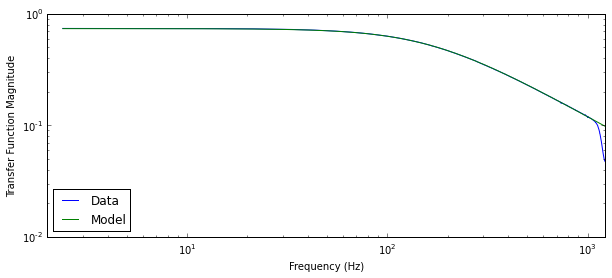

In [10]:
m= exp(-1j*pfinal[2]*w)*xfer_model(pfinal,w,rin)
tt=t*exp(-1j*w*pfinal[2])
figure(figsize=(10,4))
xlim([2.,1225.])
xlabel('Frequency (Hz)')
ylabel('Transfer Function Magnitude')
loglog(f,abs(tt),label='Data') #plot it up in a log/log plot.
loglog(f,abs(m),label='Model') #plot the model magnitude
legend(loc=3)

To look at the fit more closely, plot the difference between the data and the model - the residual. Since they are complex numbers, plot the difference between the real part of the model and the data in blue and the imaginary difference in green. 

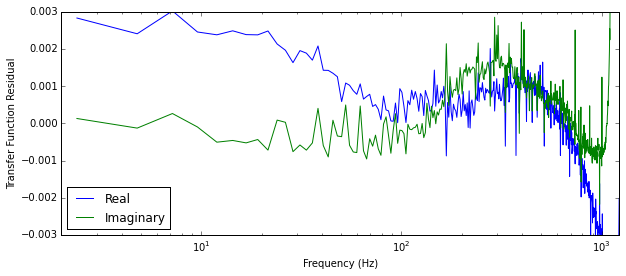

In [11]:
figure(figsize=(10,4))
ylim([-3.e-3,3.e-3])
xlim([2.,1225.])
xlabel('Frequency (Hz)')
ylabel('Transfer Function Residual')
semilogx(f,tt.real-m.real,label='Real')
semilogx(f,tt.imag-m.imag,label='Imaginary')
legend(loc=3)

Plot the phase of the transfer function data and fit.

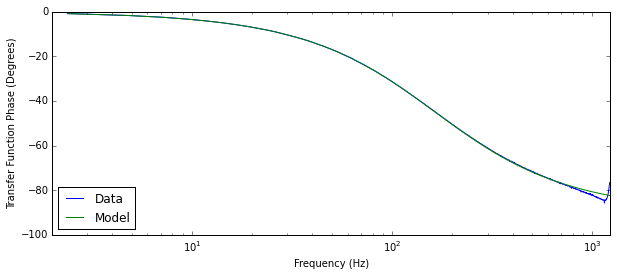

In [12]:
figure(figsize=(10,4))
ylim([-100.,0.])
xlim([2.,1225.])
xlabel('Frequency (Hz)')
ylabel('Transfer Function Phase (Degrees)')
semilogx(f,180.*angle(tt)/pi,label='Data')
semilogx(f,180.*angle(m)/pi,label='Model')
legend(loc=3)